In [1]:
import drawing
# import imp
# imp.reload(drawing)

In [2]:
import numpy as np

import os

import torch

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
print(device)


cuda:3


In [3]:
from collections import defaultdict

data_dir = "data"
alphabet = [
    '\x00', ' ', '!', '"', '#', "'", '(', ')', ',', '-', '.',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';',
    '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
    'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
    'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
    'y', 'z'
]
alphabet_ord = list(map(ord, alphabet))
alpha_to_num = defaultdict(int, list(map(reversed, enumerate(alphabet))))
num_to_alpha = defaultdict(int, list(enumerate(alphabet)))


In [4]:
strokes = np.load(os.path.join(data_dir, 'x.npy'))
stroke_lens = np.load(os.path.join(data_dir, 'x_len.npy'))
texts = np.load(os.path.join(data_dir, 'c.npy'))
text_lens = np.load(os.path.join(data_dir, 'c_len.npy'))
w_id = np.load(os.path.join(data_dir, 'w_id.npy'))

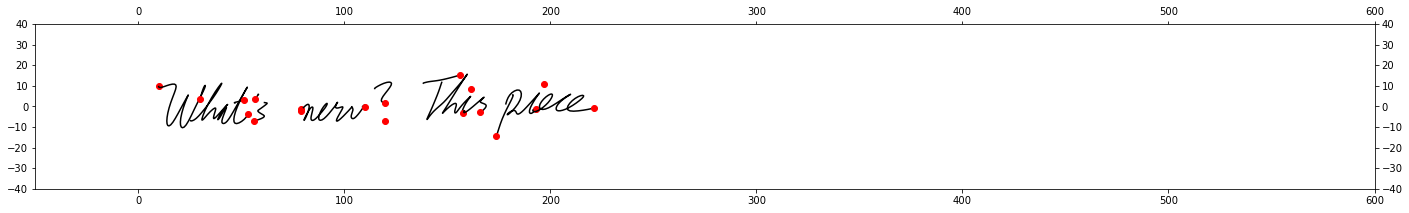

What 's new? This piece
drawing length: 674, text_length: 24


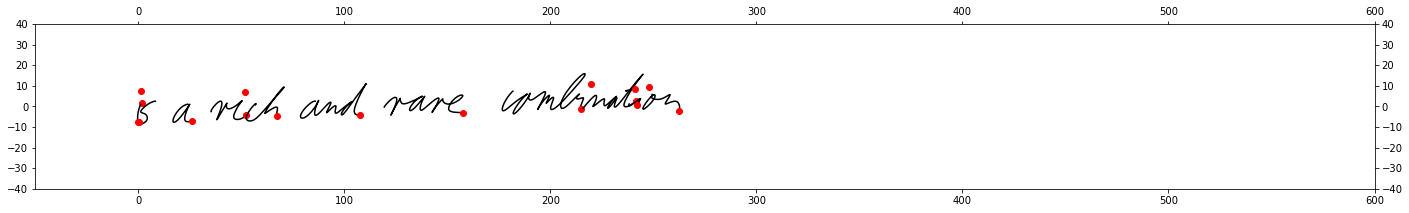

is a rich and rare combination
drawing length: 721, text_length: 31


In [5]:
for i in range(2):
    drawing.draw(strokes[i])
    print(drawing.decode_ascii(texts[i]))
    print(f"drawing length: {stroke_lens[i]}, text_length: {text_lens[i]}")

In [6]:
text_indexed = torch.tensor(texts)
max_text_len = max(text_lens)
print(max_text_len)
max_index = torch.max(text_indexed)
print(max_index)

65
tensor(72, dtype=torch.int8)


In [7]:
text_one_hots = torch.zeros((len(texts), max_text_len, max_index + 1))
text_masks = torch.ones((len(texts), max_text_len))
for i, string in enumerate(texts):
    for j, c in enumerate(string[:max_text_len]):
        text_one_hots[i, j, c] = 1
    text_masks[i, text_lens[i]:] = 0
    
text_one_hots.shape
text_masks.shape


torch.Size([11911, 65, 73])

torch.Size([11911, 65])

In [8]:
import torch 
from torch import tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [9]:
class HandwritingDataset(Dataset):
    def __init__(self,
                 strokes,
                 stroke_lengths,
                 text_one_hots,
                 text_lengths):
        self.strokes = strokes
        self.stroke_lengths = stroke_lengths
        self.text_one_hots = text_one_hots
        self.text_lengths = text_lengths
        
    def __len__(self):
        return self.strokes.shape[0]
    
    def __getitem__(self, idx):
        return self.strokes[idx], self.stroke_lengths[idx], self.text_one_hots[idx], self.text_lengths[idx]
    
train_dataset = HandwritingDataset(
    strokes[:10000],
    stroke_lens[:10000],
    text_one_hots[:10000],
    text_lens[:10000])
test_dataset = HandwritingDataset(
    strokes[10000:],
    stroke_lens[10000:],
    text_one_hots[10000:],
    text_lens[10000:])

In [10]:
class HandWritingSynthesis(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 vocab_size,
                 n_output_mixtures,
                 n_attn_mixtures):
        super(HandWritingSynthesis, self).__init__()
        # input params
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_output_mixtures = n_output_mixtures
        self.n_attn_mixtures = n_attn_mixtures
        self.vocab_size = vocab_size
        
        # inferred sizes of layer params
        self.output_size = 6*n_output_mixtures+1
        self.n_attn_params = 3*n_attn_mixtures
        
        # Layers needed
        
        # First LSTM layer
        self.lstm1 = nn.LSTMCell(
            input_size+vocab_size, hidden_size)
        
        # Layer to compute attn params from hidden state
        self.attn_params = nn.Linear(hidden_size, self.n_attn_params)
        
        # Second LSTM layer
        self.lstm2 = nn.LSTMCell(
            input_size+hidden_size+vocab_size, hidden_size)
        
        # Layer to compute params for output gaussian
        self.output_params = nn.Linear(
            2*hidden_size, self.output_size)
        
        
    def forward(self,
                stroke_point,     # (batch, input_size=3)
                text_onehot,      # (batch, max_text_len, vocab_size)
                text_length,      # (batch, 1)
                h1_prev, c1_prev, # (batch, hidden_size)
                h2_prev, c2_prev, # (batch, hidden_size)
                attn_prev,        # (batch, vocab_size)
                attn_kappa_old):  # (batch, n_attn_mixtures)
        
        # First LSTM Layer
        h1_new, c1_new = self.lstm1(
            torch.cat((stroke_point, attn_prev), dim=-1).to(device),
            (h1_prev, c1_prev))
        
        # Attention calculations
        attn_params = self.attn_params(h1_new) # (batch, n_attn_params)
        
        attn_new, attn_kappa_new, phi_new = self.calculate_attn(
            attn_params, text_onehot, text_length, attn_kappa_old) 
        
        # Second LSTM layer
        h2_new, c2_new = self.lstm2(
            torch.cat((stroke_point, h1_new, attn_new), dim=-1).to(device),
            (h2_prev, c2_prev))
        
        out_params = self.output_params(torch.cat((h1_new, h2_new), dim=-1).to(device))
        
        return out_params, h1_new, c1_new, h2_new, c2_new, attn_new, attn_kappa_new, phi_new
    
    def calculate_attn(self, attn_params, text_onehot, text_length, attn_kappa_old):
        alpha = torch.exp(attn_params[:, :self.n_attn_mixtures])
        beta = torch.exp(attn_params[:, self.n_attn_mixtures:2*self.n_attn_mixtures])
#         print(attn_kappa_old.shape)
#         print(torch.exp(attn_params[:, 2*self.n_attn_mixtures:]).shape)
        kappa = attn_kappa_old + torch.exp(attn_params[:, 2*self.n_attn_mixtures:])
        
        def get_phi(i):
#             print(beta.shape, kappa.shape, alpha.shape)
            return torch.sum(alpha * torch.exp(-beta * (kappa - i)**2), -1)
        
        max_len = torch.max(text_length)
        phi = torch.zeros(alpha.shape[0], max_len, device=device)
        for i in range(max_len):
            phi[:,i] = get_phi(i)
#         print(phi)
#         print(text_onehot[:,:max_len,:].shape)
#         print(phi.unsqueeze(-1).shape)
#         print((text_onehot[:,:max_len,:]*phi.unsqueeze(-1)).shape)
        attn = torch.sum(text_onehot[:,:max_len,:]*phi.unsqueeze(-1), axis=1)
#         print(attn)
#         print(attn.shape)
        return attn, kappa, phi
        

In [11]:
def negative_log_likelihood(batch_params,       # (batch_size, 6*n_output_mixtures+1)
                            batch_targets,      # (batch_size, 3)
                            n_output_mixtures,
                            args):  
    batch_size = batch_params.shape[0]
    
    K = args["n_output_mixtures"]

    # end of stroke probability, last colmn in the params
    es = 1/(1 + torch.exp(batch_params[:,-1]))    # (batch_size, 1)
    
    # mixture weights
    pis = nn.Softmax(1)(batch_params[:,0:K]) # (batch_size, n_output_mixtures)
    
    # Means, sigmas and correlations of the mixture gaussians
    mus = batch_params[:, K:3*K].reshape(-1, K, 2)            # (batch_size, n_output_mixtures, 2)
    sigmas = torch.exp(batch_params[:, 3*K:5*K].reshape(-1, K, 2))  # (batch_size, n_output_mixtures, 2)
    phos = torch.tanh(batch_params[:, 5*K:6*K].reshape(-1, K, 1))   # (batch_size, n_output_mixtures, 1)

    # Calculate covariance matrices for the mixture gaussians
    covs = torch.zeros(batch_size, K, 2, 2, device=args["device"])    # (batch_size, n_output_mixtures, 2, 2)
    covs[:,:,0,0] = sigmas[:,:,0] ** 2
    covs[:,:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
    covs[:,:,1,0] = covs[:,:,0,1]
    covs[:,:,1,1] = sigmas[:,:,1] ** 2

    # multivariate gaussians for each all means and covariance matrices
    distributions = torch.distributions.MultivariateNormal(mus, covs)  # (batch_size, n_output_mixtures)

    target_coords = batch_targets[:,0:2].unsqueeze(1).repeat_interleave(  
        torch.tensor([K], device=device), dim=1)           # (batch_size, n_output_mixtures, 2)
    stroke_lift = batch_targets[:,-1]                            # (batch_size, 1)

    eps = 1e-8
    probs = torch.exp(distributions.log_prob(target_coords) + eps)   # (batch_size, n_output_mixtures)
    probs = torch.where(probs < 0.000000001, torch.zeros_like(probs) + 0.000000001, probs)

    batch_loss = - (torch.log((pis*probs).sum(dim=1))).sum() - (torch.log(es)*stroke_lift).sum() - (torch.log(1 - es)*(1-stroke_lift)).sum()
    return batch_loss/batch_size

In [12]:
def get_batch_sizes(strokes, stroke_lengths, text_onehots, text_lengths):
    
    stroke_lengths_sorted, perm_idx = stroke_lengths.sort(0, descending=True)
    
    strokes_sorted = strokes[perm_idx]
    text_onehots_sorted = text_onehots[perm_idx]
    text_lengths_sorted = text_lengths[perm_idx]
    
    bs = strokes.shape[0]
    num_timesteps = torch.max(stroke_lengths)-1
    
    batch_sizes = torch.tensor([bs] * num_timesteps, device=device)
    for i in range(len(stroke_lengths_sorted)-1, 0, -1):
        bs -= 1
        batch_sizes[stroke_lengths_sorted[i]-1:stroke_lengths_sorted[i-1]-1] = bs
    return strokes_sorted, stroke_lengths_sorted, text_onehots_sorted, text_lengths_sorted, batch_sizes
    

In [18]:
def train(model,
          strokes,
          stroke_lengths,
          text_onehots,
          text_lengths,
          optimizer,
          args,
          h1, c1, h2, c2, attn, attn_kappa):
    optimizer.zero_grad()
    strokes = strokes.to(args["device"])
    stroke_lengths = stroke_lengths.to(args["device"])
    text_onehots = text_onehots.to(args["device"])
    text_lengths = text_lengths.to(args["device"])
    
    # prepare so that we can handle varying length inputs in training
    strokes, stroke_lengths, text_onehots, text_lengths, batch_sizes = get_batch_sizes(
        strokes, stroke_lengths, text_onehots, text_lengths)
    
    loss = 0
    # At timestamp t, we have to look at only batch_sizes[t] entries
    for t in range(len(batch_sizes)):
        bs = batch_sizes[t]
        out_params, h1, c1, h2, c2, attn, attn_kappa, phi_new = model(
            stroke_point=strokes[:bs,t],
            text_onehot=text_onehots[:bs],
            text_length=text_lengths[:bs],
            h1_prev=h1[:bs],
            c1_prev=c1[:bs],
            h2_prev=h2[:bs],
            c2_prev=c2[:bs],
            attn_prev=attn[:bs],
            attn_kappa_old=attn_kappa[:bs])
        
        loss += negative_log_likelihood(
            out_params,
            strokes[:bs, t+1],
            args["n_output_mixtures"],
            args)
        
    loss /= len(batch_sizes)
    loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
    optimizer.step()
    return loss.item()


In [19]:
# parameters

args = {}
args["input_size"] = 3
args["hidden_size"] = 500
args["vocab_size"] = text_one_hots.shape[-1]
args["n_output_mixtures"] = 20
args["n_attn_mixtures"] = 3
args["batch_size"] = 16
args["device"] = 'cuda:3' if torch.cuda.is_available() else 'cpu'
args["n_epochs"] = 3
args["lr"] = 0.00001

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=args["batch_size"])
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=args["batch_size"])

model = HandWritingSynthesis(args["input_size"],
                             args["hidden_size"],
                             args["vocab_size"],
                             args["n_output_mixtures"],
                             args["n_attn_mixtures"])
model.to(device)

optim = torch.optim.Adam(model.parameters(), lr = args["lr"])

print(args["device"])

HandWritingSynthesis(
  (lstm1): LSTMCell(76, 500)
  (attn_params): Linear(in_features=500, out_features=9, bias=True)
  (lstm2): LSTMCell(576, 500)
  (output_params): Linear(in_features=1000, out_features=121, bias=True)
)

cuda:3


n_iter: 0 of 1875, loss: 0.7522482872009277, timeElapsed: 14.134414196014404
n_iter: 5 of 1875, loss: 3.805930995941162, timeElapsed: 81.74743127822876
n_iter: 10 of 1875, loss: 3.799843740463257, timeElapsed: 157.6109745502472
n_iter: 15 of 1875, loss: 3.791511344909668, timeElapsed: 226.5098159313202
n_iter: 20 of 1875, loss: 3.7925368785858153, timeElapsed: 292.7067277431488
n_iter: 25 of 1875, loss: 3.8172190189361572, timeElapsed: 359.98790311813354
n_iter: 30 of 1875, loss: 3.8095240116119387, timeElapsed: 430.143114566803
n_iter: 35 of 1875, loss: 3.826555347442627, timeElapsed: 495.87217259407043
n_iter: 40 of 1875, loss: 3.778615951538086, timeElapsed: 571.7610657215118
n_iter: 45 of 1875, loss: 3.7514700889587402, timeElapsed: 641.0391783714294
n_iter: 50 of 1875, loss: 3.7539470195770264, timeElapsed: 707.9474952220917
n_iter: 55 of 1875, loss: 3.7596354484558105, timeElapsed: 785.1674704551697
n_iter: 60 of 1875, loss: 3.7093649387359617, timeElapsed: 862.2179164886475
n_it

n_iter: 535 of 1875, loss: 2.4636693477630613, timeElapsed: 8022.832562923431
n_iter: 540 of 1875, loss: 2.484794187545776, timeElapsed: 8098.570989370346
n_iter: 545 of 1875, loss: 2.520483303070068, timeElapsed: 8174.095044136047
n_iter: 550 of 1875, loss: 2.5284329891204833, timeElapsed: 8249.47864818573
n_iter: 555 of 1875, loss: 2.4721367835998533, timeElapsed: 8318.451585292816
n_iter: 560 of 1875, loss: 2.524290943145752, timeElapsed: 8393.91756105423
n_iter: 565 of 1875, loss: 2.5062094211578367, timeElapsed: 8467.93409204483
n_iter: 570 of 1875, loss: 2.4809762477874755, timeElapsed: 8538.71858215332
n_iter: 575 of 1875, loss: 2.440679836273193, timeElapsed: 8613.866579771042
n_iter: 580 of 1875, loss: 2.4215099811553955, timeElapsed: 8689.41856098175
n_iter: 585 of 1875, loss: 2.443539571762085, timeElapsed: 8773.773950099945
n_iter: 590 of 1875, loss: 2.485647106170654, timeElapsed: 8847.310413122177
n_iter: 595 of 1875, loss: 2.452324914932251, timeElapsed: 8926.02531409263

n_iter: 1060 of 1875, loss: 1.6918177366256715, timeElapsed: 15873.439980983734
n_iter: 1065 of 1875, loss: 1.6989929676055908, timeElapsed: 15946.274432182312
n_iter: 1070 of 1875, loss: 1.6820632696151734, timeElapsed: 16019.11875629425
n_iter: 1075 of 1875, loss: 1.6791911125183105, timeElapsed: 16090.337982177734
n_iter: 1080 of 1875, loss: 1.7140848636627197, timeElapsed: 16166.496323108673
n_iter: 1085 of 1875, loss: 1.680433177947998, timeElapsed: 16229.638732671738
n_iter: 1090 of 1875, loss: 1.7084715127944947, timeElapsed: 16296.509578943253
n_iter: 1095 of 1875, loss: 1.7495062351226807, timeElapsed: 16366.925343990326
n_iter: 1100 of 1875, loss: 1.6896445989608764, timeElapsed: 16450.56227374077
n_iter: 1105 of 1875, loss: 1.6669023275375365, timeElapsed: 16518.421880960464
n_iter: 1110 of 1875, loss: 1.646118664741516, timeElapsed: 16594.816985607147
n_iter: 1115 of 1875, loss: 1.6510395050048827, timeElapsed: 16664.10583472252
n_iter: 1120 of 1875, loss: 1.585800170898437

n_iter: 1580 of 1875, loss: 1.0835385084152223, timeElapsed: 23679.11333656311
n_iter: 1585 of 1875, loss: 1.1070018529891967, timeElapsed: 23751.837418556213
n_iter: 1590 of 1875, loss: 1.1623947024345398, timeElapsed: 23817.981836795807
n_iter: 1595 of 1875, loss: 1.0087665677070619, timeElapsed: 23901.135238409042
n_iter: 1600 of 1875, loss: 1.0408936500549317, timeElapsed: 23969.279566049576
n_iter: 1605 of 1875, loss: 1.0003237128257751, timeElapsed: 24050.102893829346
n_iter: 1610 of 1875, loss: 1.1291509866714478, timeElapsed: 24132.785286188126
n_iter: 1615 of 1875, loss: 1.0158504843711853, timeElapsed: 24208.65363097191
n_iter: 1620 of 1875, loss: 1.0373414039611817, timeElapsed: 24285.157582759857
n_iter: 1625 of 1875, loss: 0.9128487348556519, timeElapsed: 24362.325830698013
n_iter: 1630 of 1875, loss: 1.0521562695503235, timeElapsed: 24447.003835201263
n_iter: 1635 of 1875, loss: 1.0010061144828797, timeElapsed: 24535.17082118988
n_iter: 1640 of 1875, loss: 1.0954453229904

<Figure size 432x288 with 0 Axes>

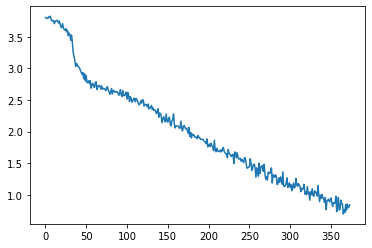

In [20]:
print_every = 5
n_iters = 0
losses = []
total_loss = 0
n_epochs = args["n_epochs"]

import time
start = time.time()

h1 = torch.zeros(args["batch_size"], args["hidden_size"], device=args["device"])
c1 = torch.zeros(args["batch_size"], args["hidden_size"], device=args["device"])
h2 = torch.zeros(args["batch_size"], args["hidden_size"], device=args["device"])
c2 = torch.zeros(args["batch_size"], args["hidden_size"], device=args["device"])
attn = torch.zeros(args["batch_size"], args["vocab_size"], device=args["device"])
attn_kappa = torch.zeros(args["batch_size"], args["n_attn_mixtures"], device=args["device"])

for i in range(args["n_epochs"]):
    for strokes, stroke_lengths, text_onehots, text_lengths in train_dataloader:
        loss = train(model,
                     strokes,
                     stroke_lengths,
                     text_onehots,
                     text_lengths,
                     optim,
                     args,
                     h1, c1, h2, c2, attn, attn_kappa)
        
        total_loss += loss
        
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_attention.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

n_iter: 1875 of 1875, loss: 0.890304684638977, timeElapsed: 28170.497014522552
n_iter: 1880 of 1875, loss: 0.7257333159446716, timeElapsed: 28246.193757772446
n_iter: 1885 of 1875, loss: 0.7296022415161133, timeElapsed: 28315.834616184235
n_iter: 1890 of 1875, loss: 0.7472152352333069, timeElapsed: 28390.344698429108
n_iter: 1895 of 1875, loss: 0.7490496873855591, timeElapsed: 28466.791275262833
n_iter: 1900 of 1875, loss: 0.8066174864768982, timeElapsed: 28535.653702259064
n_iter: 1905 of 1875, loss: 0.8912911057472229, timeElapsed: 28615.848470926285
n_iter: 1910 of 1875, loss: 0.6973121643066407, timeElapsed: 28695.075179100037
n_iter: 1915 of 1875, loss: 0.7294893622398376, timeElapsed: 28769.878893613815
n_iter: 1920 of 1875, loss: 0.6961324095726014, timeElapsed: 28846.383945465088
n_iter: 1925 of 1875, loss: 0.7514953255653382, timeElapsed: 28921.278316497803
n_iter: 1930 of 1875, loss: 0.8120403230190277, timeElapsed: 28992.240597963333
n_iter: 1935 of 1875, loss: 0.64344395995

n_iter: 2395 of 1875, loss: 0.4066649079322815, timeElapsed: 35984.666347026825
n_iter: 2400 of 1875, loss: 0.42791364192962644, timeElapsed: 36058.23540186882
n_iter: 2405 of 1875, loss: 0.3565658688545227, timeElapsed: 36133.631314754486
n_iter: 2410 of 1875, loss: 0.320699904859066, timeElapsed: 36210.222351789474
n_iter: 2415 of 1875, loss: 0.3413945555686951, timeElapsed: 36288.634139060974
n_iter: 2420 of 1875, loss: 0.3185285836458206, timeElapsed: 36375.73143696785
n_iter: 2425 of 1875, loss: 0.46646528840065005, timeElapsed: 36442.60139012337
n_iter: 2430 of 1875, loss: 0.37704997062683104, timeElapsed: 36517.1005423069
n_iter: 2435 of 1875, loss: 0.28295893371105196, timeElapsed: 36589.926112651825
n_iter: 2440 of 1875, loss: 0.30360374599695206, timeElapsed: 36659.55992817879
n_iter: 2445 of 1875, loss: 0.36267904490232467, timeElapsed: 36731.894361019135
n_iter: 2450 of 1875, loss: 0.38614720702171323, timeElapsed: 36798.616632938385
n_iter: 2455 of 1875, loss: 0.2014476977

n_iter: 2910 of 1875, loss: 0.09032168816775084, timeElapsed: 43801.82376241684
n_iter: 2915 of 1875, loss: 0.18553832918405533, timeElapsed: 43872.07136583328
n_iter: 2920 of 1875, loss: -0.015852141380310058, timeElapsed: 43953.60391497612
n_iter: 2925 of 1875, loss: 0.08512560399249196, timeElapsed: 44032.27163362503
n_iter: 2930 of 1875, loss: 0.14279246591031552, timeElapsed: 44102.358127593994
n_iter: 2935 of 1875, loss: 0.07281224168837071, timeElapsed: 44178.17632293701
n_iter: 2940 of 1875, loss: 0.008828148245811462, timeElapsed: 44249.635982990265
n_iter: 2945 of 1875, loss: 0.014038172364234925, timeElapsed: 44321.36417269707
n_iter: 2950 of 1875, loss: 0.08527196464128792, timeElapsed: 44387.53054523468
n_iter: 2955 of 1875, loss: 0.0226936555467546, timeElapsed: 44462.36724257469
n_iter: 2960 of 1875, loss: 0.13763801036402584, timeElapsed: 44537.65797305107
n_iter: 2965 of 1875, loss: -0.08100666957907379, timeElapsed: 44607.54549121857
n_iter: 2970 of 1875, loss: 0.0466

n_iter: 3420 of 1875, loss: -0.23340728282928466, timeElapsed: 51401.81567454338
n_iter: 3425 of 1875, loss: -0.08057939410209655, timeElapsed: 51470.21905565262
n_iter: 3430 of 1875, loss: -0.20274369115941226, timeElapsed: 51547.097581624985
n_iter: 3435 of 1875, loss: -0.07848666738718749, timeElapsed: 51621.90099811554
n_iter: 3440 of 1875, loss: -0.07858568765223026, timeElapsed: 51689.36046242714
n_iter: 3445 of 1875, loss: -0.1453025033697486, timeElapsed: 51760.50743794441
n_iter: 3450 of 1875, loss: -0.18866131007671355, timeElapsed: 51840.30546832085
n_iter: 3455 of 1875, loss: -0.16787885874509811, timeElapsed: 51911.01982617378
n_iter: 3460 of 1875, loss: -0.19678625972010194, timeElapsed: 51987.837604522705
n_iter: 3465 of 1875, loss: -0.1742837719619274, timeElapsed: 52055.44240784645
n_iter: 3470 of 1875, loss: -0.20110997706651687, timeElapsed: 52135.57043337822
n_iter: 3475 of 1875, loss: -0.27128728330135343, timeElapsed: 52209.49717760086
n_iter: 3480 of 1875, loss: 

<Figure size 432x288 with 0 Axes>

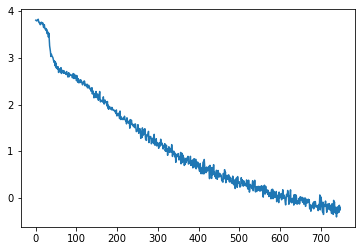

In [21]:
for i in range(args["n_epochs"]):
    for strokes, stroke_lengths, text_onehots, text_lengths in train_dataloader:
        loss = train(model,
                     strokes,
                     stroke_lengths,
                     text_onehots,
                     text_lengths,
                     optim,
                     args,
                     h1, c1, h2, c2, attn, attn_kappa)
        
        total_loss += loss
        
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_attention.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

n_iter: 3750 of 5625, loss: -0.277037525177002, timeElapsed: 56353.91459465027
n_iter: 3755 of 5630, loss: -0.25714941918849943, timeElapsed: 56439.445430994034
n_iter: 3760 of 5635, loss: -0.27471223920583726, timeElapsed: 56524.63640332222
n_iter: 3765 of 5640, loss: -0.32226519882678983, timeElapsed: 56601.65496349335
n_iter: 3770 of 5645, loss: -0.37982226610183717, timeElapsed: 56671.41478252411
n_iter: 3775 of 5650, loss: -0.28695689141750336, timeElapsed: 56739.69383716583
n_iter: 3780 of 5655, loss: -0.3059987545013428, timeElapsed: 56815.822934389114
n_iter: 3785 of 5660, loss: -0.32659683004021645, timeElapsed: 56884.737626075745
n_iter: 3790 of 5665, loss: -0.26675803661346437, timeElapsed: 56961.79075527191
n_iter: 3795 of 5670, loss: -0.47200297713279726, timeElapsed: 57039.19918131828
n_iter: 3800 of 5675, loss: -0.34552863240242004, timeElapsed: 57106.418427467346
n_iter: 3805 of 5680, loss: -0.36182762384414674, timeElapsed: 57177.093799352646
n_iter: 3810 of 5685, loss

n_iter: 4260 of 6135, loss: -0.5821557581424713, timeElapsed: 63973.37364602089
n_iter: 4265 of 6140, loss: -0.5321614503860473, timeElapsed: 64049.5184109211
n_iter: 4270 of 6145, loss: -0.4127540200948715, timeElapsed: 64132.863792181015
n_iter: 4275 of 6150, loss: -0.33944817781448366, timeElapsed: 64210.91861343384
n_iter: 4280 of 6155, loss: -0.41553462520241735, timeElapsed: 64294.038930654526
n_iter: 4285 of 6160, loss: -0.42909743189811705, timeElapsed: 64369.172067165375
n_iter: 4290 of 6165, loss: -0.4282547175884247, timeElapsed: 64448.24599099159
n_iter: 4295 of 6170, loss: -0.3707440972328186, timeElapsed: 64513.57624006271
n_iter: 4300 of 6175, loss: -0.574187308549881, timeElapsed: 64585.48918938637
n_iter: 4305 of 6180, loss: -0.5301894068717956, timeElapsed: 64664.11223912239
n_iter: 4310 of 6185, loss: -0.4502834379673004, timeElapsed: 64742.54681301117
n_iter: 4315 of 6190, loss: -0.44658502340316775, timeElapsed: 64811.156666755676
n_iter: 4320 of 6195, loss: -0.437

n_iter: 4775 of 6650, loss: -0.6100958466529847, timeElapsed: 71660.9820754528
n_iter: 4780 of 6655, loss: -0.5451262950897217, timeElapsed: 71737.56000757217
n_iter: 4785 of 6660, loss: -0.568888521194458, timeElapsed: 71811.4361653328
n_iter: 4790 of 6665, loss: -0.6038781225681304, timeElapsed: 71881.35156774521
n_iter: 4795 of 6670, loss: -0.8009637475013733, timeElapsed: 71956.24411606789
n_iter: 4800 of 6675, loss: -0.6201018750667572, timeElapsed: 72035.82620120049
n_iter: 4805 of 6680, loss: -0.6196155548095703, timeElapsed: 72121.58324575424
n_iter: 4810 of 6685, loss: -0.7856714010238648, timeElapsed: 72193.67505407333
n_iter: 4815 of 6690, loss: -0.4942354023456573, timeElapsed: 72268.34238004684
n_iter: 4820 of 6695, loss: -0.5305266201496124, timeElapsed: 72341.47754454613
n_iter: 4825 of 6700, loss: -0.4570122301578522, timeElapsed: 72420.68612909317
n_iter: 4830 of 6705, loss: -0.6891675114631652, timeElapsed: 72486.2299580574
n_iter: 4835 of 6710, loss: -0.6753755807876

n_iter: 5290 of 7165, loss: -0.6936152458190918, timeElapsed: 79435.00325894356
n_iter: 5295 of 7170, loss: -0.7364864110946655, timeElapsed: 79507.54889583588
n_iter: 5300 of 7175, loss: -0.6656299233436584, timeElapsed: 79591.09278416634
n_iter: 5305 of 7180, loss: -0.7656643629074097, timeElapsed: 79672.00935745239
n_iter: 5310 of 7185, loss: -0.85651193857193, timeElapsed: 79747.89045500755
n_iter: 5315 of 7190, loss: -0.726210868358612, timeElapsed: 79821.940751791
n_iter: 5320 of 7195, loss: -0.637508749961853, timeElapsed: 79904.2047290802
n_iter: 5325 of 7200, loss: -0.7986662030220032, timeElapsed: 79976.53100299835
n_iter: 5330 of 7205, loss: -0.7291917681694031, timeElapsed: 80051.8914411068
n_iter: 5335 of 7210, loss: -0.7499710559844971, timeElapsed: 80130.02054142952
n_iter: 5340 of 7215, loss: -0.8459332108497619, timeElapsed: 80199.78527498245
n_iter: 5345 of 7220, loss: -0.7653948903083801, timeElapsed: 80265.12691044807
n_iter: 5350 of 7225, loss: -0.6894590973854064,

<Figure size 432x288 with 0 Axes>

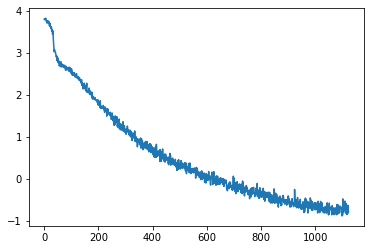

In [22]:
for i in range(args["n_epochs"]):
    for strokes, stroke_lengths, text_onehots, text_lengths in train_dataloader:
        loss = train(model,
                     strokes,
                     stroke_lengths,
                     text_onehots,
                     text_lengths,
                     optim,
                     args,
                     h1, c1, h2, c2, attn, attn_kappa)
        
        total_loss += loss
        
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs+n_iters}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_attention.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

In [ ]:
for i in range(args["n_epochs"]):
    for strokes, stroke_lengths, text_onehots, text_lengths in train_dataloader:
        loss = train(model,
                     strokes,
                     stroke_lengths,
                     text_onehots,
                     text_lengths,
                     optim,
                     args,
                     h1, c1, h2, c2, attn, attn_kappa)
        
        total_loss += loss
        
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs+n_iters}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_attention.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

n_iter: 5625 of 7500, loss: -0.7501979649066925, timeElapsed: 84407.02934455872
n_iter: 5630 of 7505, loss: -0.6661611497402191, timeElapsed: 84482.1985669136
n_iter: 5635 of 7510, loss: -0.7134190618991851, timeElapsed: 84551.22301387787
n_iter: 5640 of 7515, loss: -0.6331860154867173, timeElapsed: 84624.4446709156
n_iter: 5645 of 7520, loss: -0.7145685076713562, timeElapsed: 84700.86094737053
n_iter: 5650 of 7525, loss: -0.7058507859706878, timeElapsed: 84768.76105546951
n_iter: 5655 of 7530, loss: -0.881330919265747, timeElapsed: 84843.53577852249
n_iter: 5660 of 7535, loss: -0.7466850757598877, timeElapsed: 84903.79858803749
n_iter: 5665 of 7540, loss: -0.8055688738822937, timeElapsed: 84974.02543330193
n_iter: 5670 of 7545, loss: -0.766859495639801, timeElapsed: 85048.68143749237
n_iter: 5675 of 7550, loss: -0.9037944197654724, timeElapsed: 85125.57096147537
n_iter: 5680 of 7555, loss: -0.7751982927322387, timeElapsed: 85190.26609396935
n_iter: 5685 of 7560, loss: -0.7872273325920

In [ ]:
for i in range(args["n_epochs"]):
    for strokes, stroke_lengths, text_onehots, text_lengths in train_dataloader:
        loss = train(model,
                     strokes,
                     stroke_lengths,
                     text_onehots,
                     text_lengths,
                     optim,
                     args,
                     h1, c1, h2, c2, attn, attn_kappa)
        
        total_loss += loss
        
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs+n_iters}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_attention.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

In [16]:
a = torch.tensor([1, 2])
a.device
a.to('cuda:3')
a.device
a.to('cuda:2')
a.device

device(type='cpu')

tensor([1, 2], device='cuda:3')

device(type='cpu')

tensor([1, 2], device='cuda:2')

device(type='cpu')

In [54]:
s, l, oh, tl = next(iter(train_dataloader))

s.shape
l.shape
l
ss, sls, tos, tls, bs = get_batch_sizes(s, l, oh, tl)
bs.shape
#bs
#num_to_alpha
# for i in range(ss.shape[0]):
#     drawing.draw(ss[i])
#     indexed = (tos[i] == 1).nonzero(as_tuple=True)[1]
#     print(sls[i].item(), tls[i].item())
#     string = "".join([num_to_alpha[j.item()] for j in indexed])
#     print(string)

torch.Size([16, 1200, 3])

torch.Size([16])

tensor([507, 830, 191, 725, 794, 255, 580, 521, 558, 592, 550, 698, 911, 624,
        570, 805], dtype=torch.int16)

cpu cpu


torch.Size([910])

In [23]:
s.shape
s[:, 0].shape
tos.shape
tos[:2].shape

torch.Size([16, 1200, 3])

torch.Size([16, 3])

torch.Size([16, 65, 73])

torch.Size([2, 65, 73])

In [101]:
s, l, oh, tl = next(iter(train_dataloader))


torch.Size([16, 1200, 3])

torch.Size([16])

torch.Size([16, 65, 73])

torch.Size([16])

In [93]:
input_size = 3
hidden_size = 10
vocab_size = 5
max_text_len = 15
n_output_mixtures = 6
n_attn_mixtures = 4
batch_size = 2

m = HandWritingSynthesis(
    input_size, hidden_size, vocab_size, n_output_mixtures, n_attn_mixtures)

stroke_point = torch.randn(batch_size, input_size)
text_onehot = torch.randn(batch_size, max_text_len, vocab_size)
text_length = torch.tensor([7, 3])
h = torch.randn(batch_size, hidden_size)
attn_prev = torch.randn(batch_size, vocab_size)
attn_kappa_old = torch.randn(batch_size, n_attn_mixtures)

o = m(stroke_point, text_onehot, text_length, h, h, h, h, attn_prev, attn_kappa_old)
out_params, h1_new, c1_new, h2_new, c2_new, attn_new, attn_kappa_new, phi_new = o
print("outputs")
for k in [out_params, h1_new, c1_new, h2_new, c2_new, attn_new, attn_kappa_new, phi_new]:
    print(k.shape)
    
negative_log_likelihood(out_params.to(device),
                        torch.randn(batch_size, input_size).to(device),
                        n_output_mixtures)

torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4]) torch.Size([2, 4]) torch.Size([2, 4])
torch.Size([2, 4]) torch.Size([2, 4]) torch.Size([2, 4])
torch.Size([2, 4]) torch.Size([2, 4]) torch.Size([2, 4])
torch.Size([2, 4]) torch.Size([2, 4]) torch.Size([2, 4])
torch.Size([2, 4]) torch.Size([2, 4]) torch.Size([2, 4])
torch.Size([2, 4]) torch.Size([2, 4]) torch.Size([2, 4])
torch.Size([2, 4]) torch.Size([2, 4]) torch.Size([2, 4])
tensor([[2.7961e-01, 2.0991e+00, 3.8042e+00, 2.3424e+00, 3.4777e-01, 8.1364e-03,
         2.6485e-05],
        [1.2174e-01, 1.6763e+00, 4.3558e+00, 1.9539e+00, 1.2757e-01, 1.0763e-03,
         1.1129e-06]], grad_fn=<CopySlices>)
torch.Size([2, 7, 5])
torch.Size([2, 7, 1])
torch.Size([2, 7, 5])
tensor([[10.2345, -3.2051,  7.0200,  4.5399,  5.9539],
        [-3.0935, -2.6876, -0.3168,  2.6474,  6.9234]], grad_fn=<SumBackward1>)
torch.Size([2, 5])
outputs
torch.Size([2, 37])
torch.Size([2, 10])
torch.Size([2, 10])
torch.Size([2, 10])
torch.Size([2, 10])
torch.

tensor(2.6724, device='cuda:3', grad_fn=<DivBackward0>)

In [78]:
targets = torch.randn(2, 3)
t = targets[:,0:2].unsqueeze(1).repeat_interleave(torch.tensor([7]), dim=1)
t.shape
t

mu = torch.randn(2, 7, 2)
conv = torch.zeros(2, 7, 2, 2)
conv[:, :, 0, 0] = 1
conv[:, :, 1, 1] = 1
distributions = torch.distributions.MultivariateNormal(mu, conv)
distributions.log_prob(t)

torch.Size([2, 7, 2])

tensor([[[-1.2574,  1.0405],
         [-1.2574,  1.0405],
         [-1.2574,  1.0405],
         [-1.2574,  1.0405],
         [-1.2574,  1.0405],
         [-1.2574,  1.0405],
         [-1.2574,  1.0405]],

        [[-0.5187, -0.7415],
         [-0.5187, -0.7415],
         [-0.5187, -0.7415],
         [-0.5187, -0.7415],
         [-0.5187, -0.7415],
         [-0.5187, -0.7415],
         [-0.5187, -0.7415]]])

tensor([[-2.0744, -5.9109, -2.6427, -3.7536, -4.1560, -6.5291, -5.9577],
        [-3.1456, -2.0572, -2.4134, -2.0335, -2.2987, -1.8482, -5.0668]])

In [20]:
a = torch.ones(3, 2)
b = torch.tensor(range(3)).unsqueeze(1)
a
b
a.shape
b.shape
a*b
torch.sum(a*b, axis=1)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])

tensor([[0],
        [1],
        [2]])

torch.Size([3, 2])

torch.Size([3, 1])

tensor([[0., 0.],
        [1., 1.],
        [2., 2.]])

tensor([0., 2., 4.])

In [28]:
a = torch.ones(4, 2)
b = torch.tensor([[1, 2], [1, 2], [3, 4], [3, 4]])
(b * torch.exp(-(a - 2)**2)).sum(-1)

tensor([1.1036, 1.1036, 2.5752, 2.5752])

n_iter: 0 of 6250, loss: 5.24769921875, timeElapsed: 0.3777289390563965
n_iter: 500 of 6250, loss: 1902.7812705078125, timeElapsed: 177.98896598815918
n_iter: 1000 of 6250, loss: 1353.149822265625, timeElapsed: 355.8735842704773
n_iter: 1500 of 6250, loss: 940.5091271972656, timeElapsed: 536.1023678779602
n_iter: 2000 of 6250, loss: 530.6559940490723, timeElapsed: 715.0625021457672
n_iter: 2500 of 6250, loss: 245.40275823402405, timeElapsed: 894.4145815372467
n_iter: 3000 of 6250, loss: 32.35397386813164, timeElapsed: 1073.9281713962555
n_iter: 3500 of 6250, loss: -154.57734631633758, timeElapsed: 1252.2528088092804
n_iter: 4000 of 6250, loss: -286.5899843158722, timeElapsed: 1431.2485644817352
n_iter: 4500 of 6250, loss: -363.7161818504334, timeElapsed: 1610.6385037899017
n_iter: 5000 of 6250, loss: -407.91266954040526, timeElapsed: 1789.6966035366058
n_iter: 5500 of 6250, loss: -447.7992008361816, timeElapsed: 1967.7764372825623
n_iter: 6000 of 6250, loss: -466.64762519836427, timeEl

<Figure size 432x288 with 0 Axes>

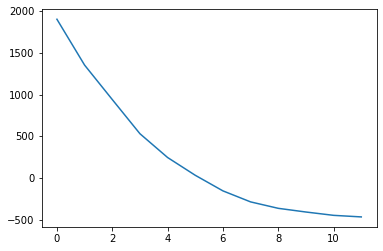

In [11]:
class HandWritingPredictionWithLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_mixtures):
        super(HandWritingPredictionWithLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_mixtures = num_mixtures
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(3*hidden_size, 6*num_mixtures+1)
        
    def forward(self, inputs, lengths, h0, c0):
        packed_x = pack_padded_sequence(
            inputs,
            lengths.cpu().numpy(),
            batch_first=True)
        packed_out1, _ = self.lstm1(packed_x, (h0, c0))
        out1, _ = pad_packed_sequence(packed_out1, batch_first=True)
        inputs = inputs[:, :out1.shape[1], :]
        packed_inp2 = pack_padded_sequence(
            torch.cat((inputs, out1), -1),
            lengths.cpu().numpy(),
            batch_first=True)
        packed_out2, _ = self.lstm2(packed_inp2, (h0, c0))
        out2, _ = pad_packed_sequence(packed_out2, batch_first=True)

        packed_inp3 = pack_padded_sequence(
            torch.cat((inputs, out2), -1),
            lengths.cpu().numpy(),
            batch_first=True)
        packed_out3, _ = self.lstm3(packed_inp3, (h0, c0))
        out3, _ = pad_packed_sequence(packed_out3, batch_first=True)

        input4 = torch.cat((out1, out2, out3), -1)
        out4 = self.linear(input4)
        return out4

input_size = 3
hidden_size = 500
batch_size = 16
n_mixtures = 20
m = HandWritingPredictionWithLSTM(input_size, hidden_size, n_mixtures).to(device)

def negative_log_likelihood(batch_params, stroke_lengths, batch_targets):  
    batch_loss = 0
    for i in range(len(stroke_lengths)):
        stroke_length = stroke_lengths[i]
        params = batch_params[i][:stroke_length-1]
        targets = batch_targets[i][1:stroke_length]
        
        es = 1/(1 + torch.exp(params[:,-1]))
        pis = nn.Softmax(1)(params[:,0:n_mixtures])
        mus = params[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
        sigmas = torch.exp(params[:, 3*n_mixtures:5*n_mixtures].reshape(-1, n_mixtures, 2))
        phos = torch.tanh(params[:, 5*n_mixtures:6*n_mixtures].reshape(-1, n_mixtures, 1))

        covs = torch.zeros(stroke_length-1, n_mixtures, 2, 2, device=device)
        tol = torch.tensor(0.000000001, device=device)
        covs[:,:,0,0] = sigmas[:,:,0] ** 2
        covs[:,:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
        covs[:,:,1,0] = covs[:,:,0,1]
        covs[:,:,1,1] = sigmas[:,:,1] ** 2


        distributions = torch.distributions.MultivariateNormal(mus, covs)

        target_coords = targets[:,0:2].unsqueeze(1).repeat_interleave(
            torch.tensor([n_mixtures], device=device), dim=1)
        stroke_lift = targets[:,-1]

        probs = torch.exp(distributions.log_prob(target_coords))
        #probs = torch.where(probs > 10, torch.zeros_like(probs) + 10, probs)
        probs = torch.where(probs < 0.000000001, torch.zeros_like(probs) + 0.000000001, probs)
    #     print(torch.log((pis*probs).sum(dim=1)).sum())
    #     print((torch.log(es)*stroke_lift).sum())
    #     print((torch.log(1 - es)*(1-stroke_lift)).sum())

        batch_loss += - (torch.log((pis*probs).sum(dim=1))).sum() - (torch.log(es)*stroke_lift).sum() - (torch.log(1 - es)*(1-stroke_lift)).sum()
    #print(batch_loss/len(stroke_lengths))
    return batch_loss/len(stroke_lengths)


def train(model, input_strokes, stroke_lengths, optimizer, h0, c0):
    #     print(f"stroke: {input_stroke.shape}")
    #     print(f"stroke_len: {stroke_len}")
    #     print(f"h0: {h0.shape}")
    #     print(f"c0: {c0.shape}")
    optimizer.zero_grad()
    input_strokes.to(device)
    stroke_lengths.to(device)
    
    # prepare for packing
    stroke_lengths_sorted, perm_idx = stroke_lengths.sort(0, descending=True)
    strokes_sorted_by_length = input_strokes[perm_idx]

    outputs = model(strokes_sorted_by_length, stroke_lengths_sorted -1 , h0, c0)

    loss = negative_log_likelihood(
        outputs,
        stroke_lengths_sorted,
        strokes_sorted_by_length
    )
    loss.backward()
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
    
    optimizer.step()
    return loss.item()

print_every = 500
n_epochs = 10
n_iters = 0
losses = []
total_loss = 0

optim = torch.optim.Adam(m.parameters(), lr = 0.00001)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

h0=torch.zeros(1, batch_size, hidden_size, device=device)
c0=torch.zeros(1, batch_size, hidden_size, device=device)

import time

start = time.time()

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(
            model=m, 
            input_strokes=strokes.to(device),
            stroke_lengths=stroke_lens,
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_padding.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

n_iter: 6500 of 6250, loss: -505.8184065551758, timeElapsed: 89.61396265029907
n_iter: 7000 of 6250, loss: -529.4838277282715, timeElapsed: 268.40514969825745
n_iter: 7500 of 6250, loss: -562.4875567626954, timeElapsed: 447.33573937416077
n_iter: 8000 of 6250, loss: -583.0712614746094, timeElapsed: 626.3008072376251
n_iter: 8500 of 6250, loss: -602.5050079956055, timeElapsed: 805.3923716545105
n_iter: 9000 of 6250, loss: -625.2581170654297, timeElapsed: 985.172333240509
n_iter: 9500 of 6250, loss: -642.0162487792969, timeElapsed: 1165.1899859905243
n_iter: 10000 of 6250, loss: -656.2877568359374, timeElapsed: 1344.2381432056427
n_iter: 10500 of 6250, loss: -677.2114589233398, timeElapsed: 1523.1813549995422
n_iter: 11000 of 6250, loss: -691.4937955322266, timeElapsed: 1702.3625676631927
n_iter: 11500 of 6250, loss: -714.8592774658204, timeElapsed: 1881.1061730384827
n_iter: 12000 of 6250, loss: -719.6984807128906, timeElapsed: 2059.9825761318207


<Figure size 432x288 with 0 Axes>

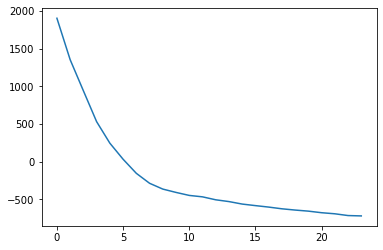

In [12]:
n_epochs = 10
import time

start = time.time()

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(
            model=m, 
            input_strokes=strokes.to(device),
            stroke_lengths=stroke_lens,
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_padding.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

n_iter: 12500 of 4375, loss: -738.1666354370117, timeElapsed: 0.35059404373168945
n_iter: 13000 of 4375, loss: -748.9617996826172, timeElapsed: 179.86119294166565
n_iter: 13500 of 4375, loss: -756.6024872436524, timeElapsed: 359.42376828193665
n_iter: 14000 of 4375, loss: -767.8976287231445, timeElapsed: 538.8364362716675
n_iter: 14500 of 4375, loss: -778.2461853637695, timeElapsed: 718.439975976944
n_iter: 15000 of 4375, loss: -788.0652469482421, timeElapsed: 896.67227602005
n_iter: 15500 of 4375, loss: -793.2050418701172, timeElapsed: 1071.9925734996796
n_iter: 16000 of 4375, loss: -794.6831823730469, timeElapsed: 1249.0075569152832
n_iter: 16500 of 4375, loss: -807.0722313842773, timeElapsed: 1428.987013578415


<Figure size 432x288 with 0 Axes>

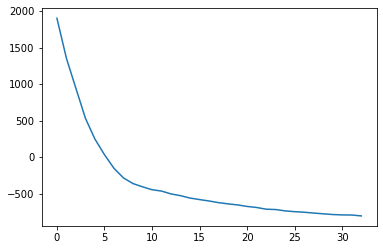

In [13]:
n_epochs = 7
import time

start = time.time()

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(
            model=m, 
            input_strokes=strokes.to(device),
            stroke_lengths=stroke_lens,
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_padding.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

n_iter: 18000 of 4375, loss: -824.0175940551758, timeElapsed: 100.59137797355652
n_iter: 18500 of 4375, loss: -830.3249935913086, timeElapsed: 279.81941866874695
n_iter: 19000 of 4375, loss: -832.641470703125, timeElapsed: 459.27060866355896
n_iter: 19500 of 4375, loss: -834.492244934082, timeElapsed: 638.2618052959442
n_iter: 20000 of 4375, loss: -851.4972506103516, timeElapsed: 818.2650921344757
n_iter: 20500 of 4375, loss: -843.7256203613281, timeElapsed: 997.6630136966705
n_iter: 21000 of 4375, loss: -855.3784816894531, timeElapsed: 1176.3963477611542
n_iter: 21500 of 4375, loss: -856.0623886108399, timeElapsed: 1355.9159197807312
n_iter: 22000 of 4375, loss: -863.3780207519532, timeElapsed: 1535.223780632019


<Figure size 432x288 with 0 Axes>

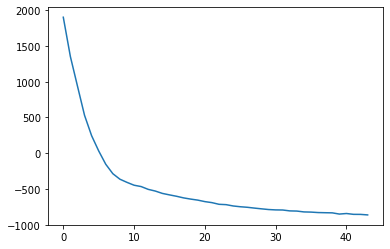

In [49]:
n_epochs = 7
import time

start = time.time()

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(
            model=m, 
            input_strokes=strokes.to(device),
            stroke_lengths=stroke_lens,
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_padding.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

In [50]:
def sample_drawing():
    timestamps = 1200

    with torch.no_grad():
        h1n=torch.zeros(1, 1, hidden_size, device=device)
        c1n=torch.zeros(1, 1, hidden_size, device=device)
        h2n=torch.zeros(1, 1, hidden_size, device=device)
        c2n=torch.zeros(1, 1, hidden_size, device=device)
        h3n=torch.zeros(1, 1, hidden_size, device=device)
        c3n=torch.zeros(1, 1, hidden_size, device=device)
        predictions = torch.zeros(timestamps, 3, device=device)
        predictions[0, 2] = 1
        for i in range(timestamps-1):
            x = predictions[i].unsqueeze(0).unsqueeze(0)
            
            out1, (h1n, c1n) = m.lstm1(x, (h1n, c1n))
            out2, (h2n, c2n) = m.lstm2(torch.cat((x, out1), -1), (h2n, c2n))
            out3, (h3n, c3n) = m.lstm3(torch.cat((x, out2), -1), (h3n, c3n))
            input4 = torch.cat((out1, out2, out3), -1)
            params = m.linear(input4)[0]

            es = 1/(1 + torch.exp(params[:,-1]))
            pis = nn.Softmax(1)(params[:,0:n_mixtures])
            mus = params[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
            sigmas = torch.exp(params[:, 3*n_mixtures:5*n_mixtures].reshape(-1, n_mixtures, 2))
            phos = torch.tanh(params[:, 5*n_mixtures:6*n_mixtures].reshape(-1, n_mixtures, 1))

            covs = torch.zeros(n_mixtures, 2, 2, device=device)
            tol = torch.tensor(0.000000001, device=device)
            covs[:,0,0] = sigmas[:,:,0] ** 2
            covs[:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
            covs[:,1,0] = covs[:,0,1]
            covs[:,1,1] = sigmas[:,:,1] ** 2

            sample_index = np.random.choice(
                range(n_mixtures),
                p = pis.squeeze().cpu().numpy())

            pen_off = np.random.binomial(1,es.item())

            sample_point = np.random.multivariate_normal(
                mus.squeeze()[sample_index].cpu().numpy(),
                covs[sample_index].cpu().numpy())

            predictions[i+1, 0] = sample_point[0]
            predictions[i+1, 1] = sample_point[1]
            predictions[i+1, 2] = pen_off


    drawing.draw(predictions.cpu(), align_strokes=False, denoise_strokes=False, plot_end_points=False)


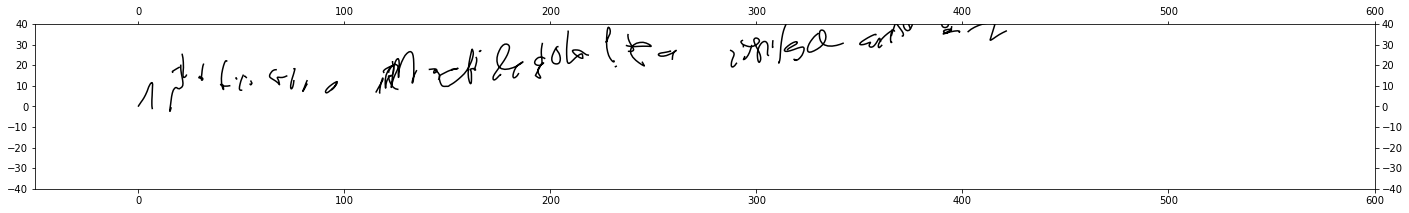

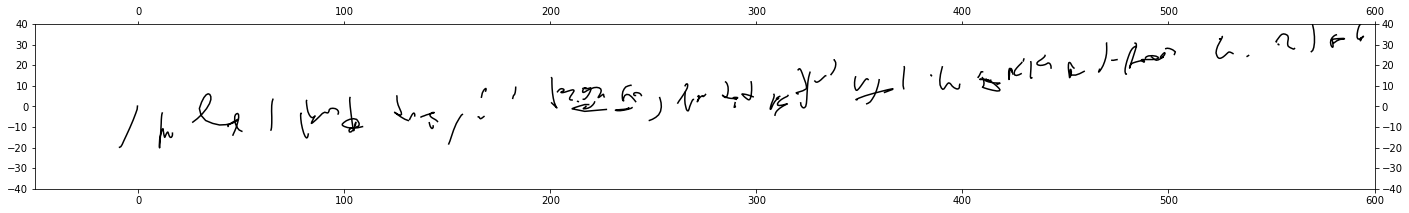

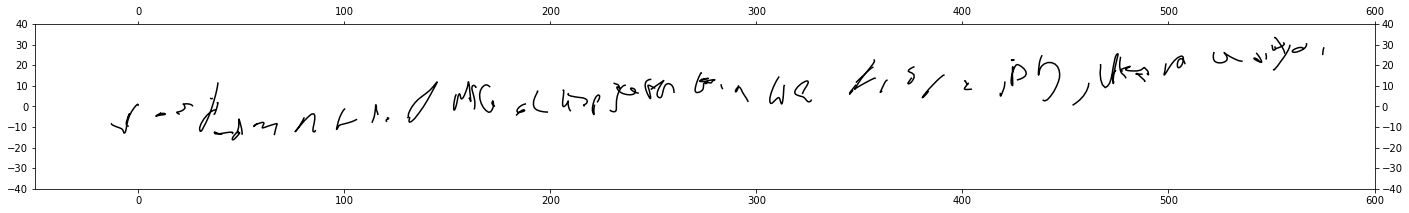

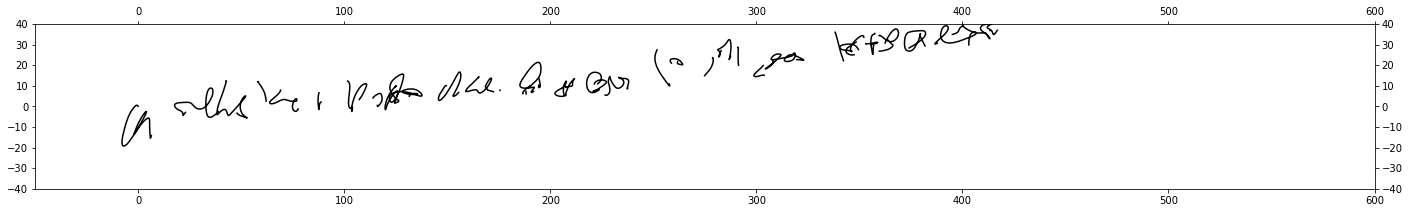

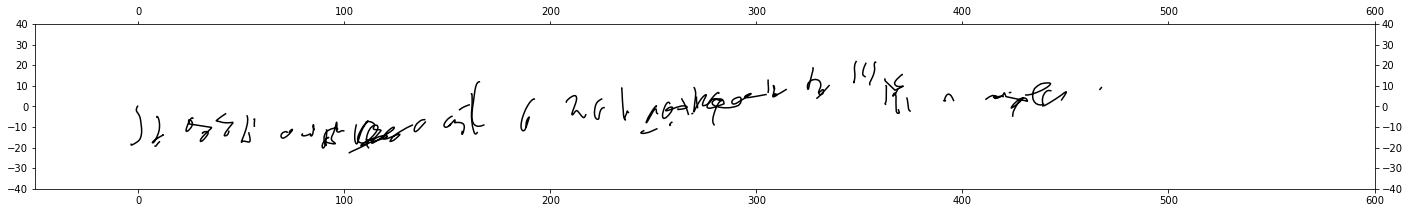

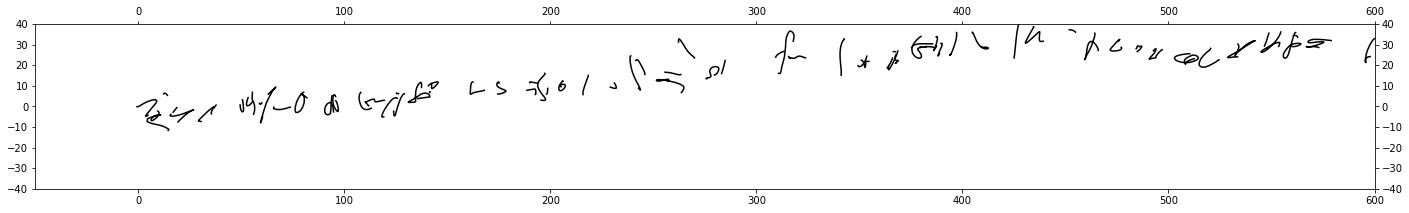

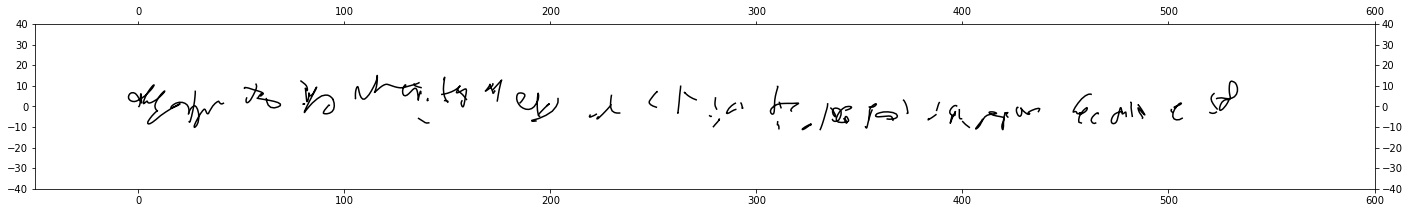

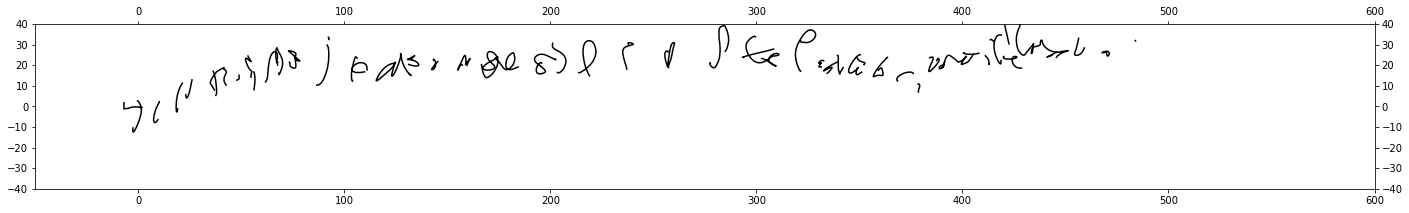

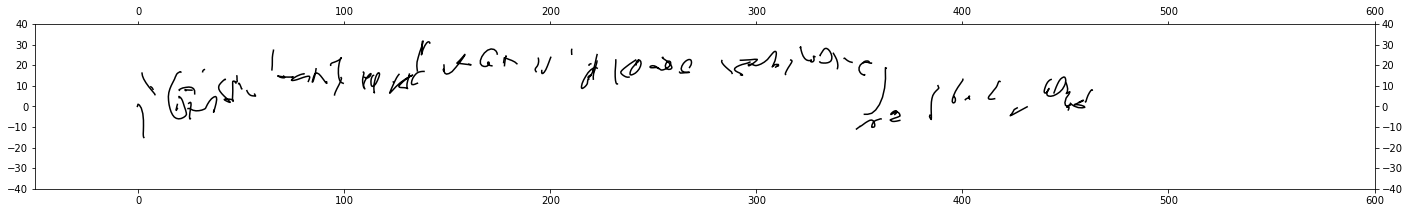

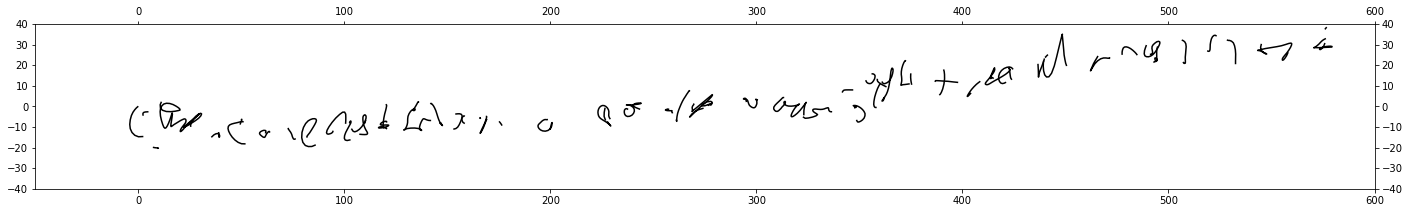

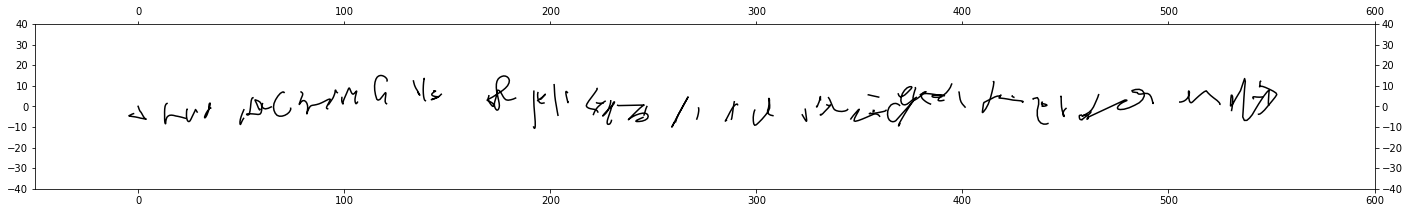

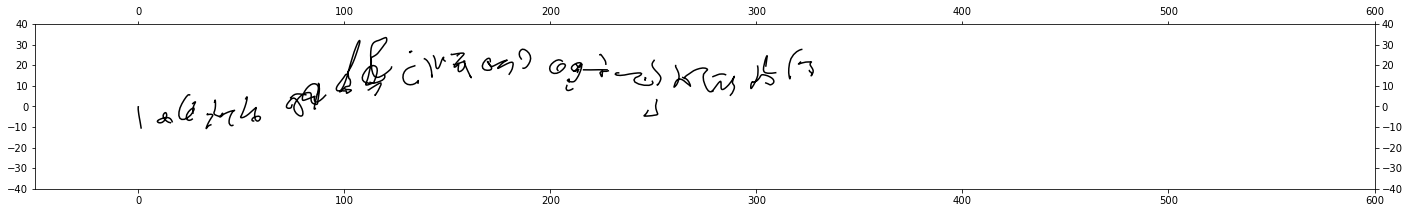

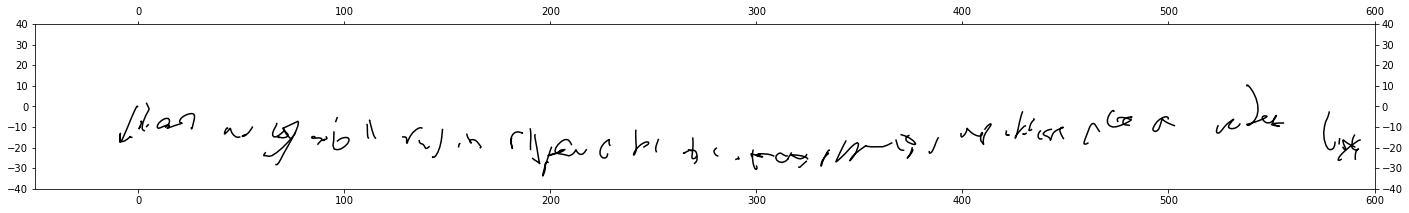

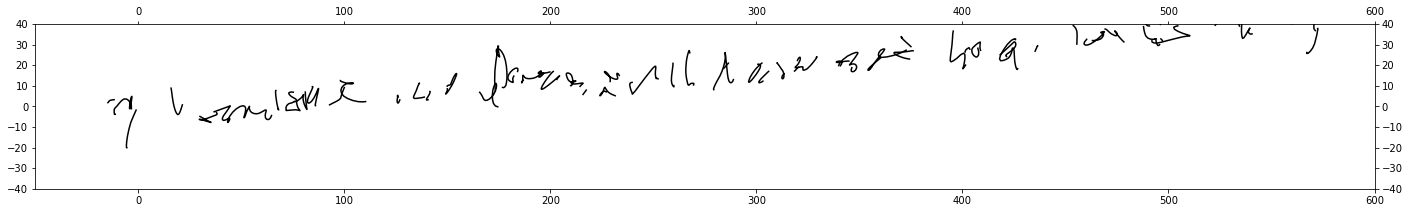

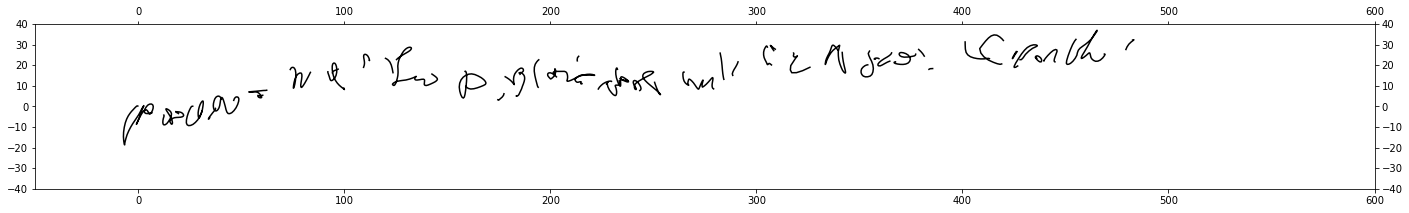

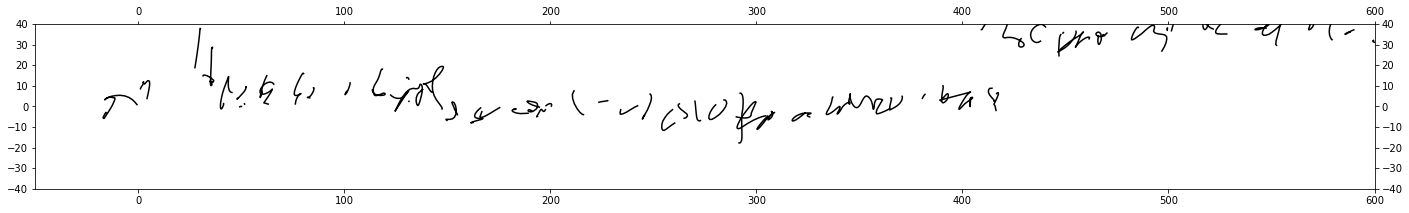

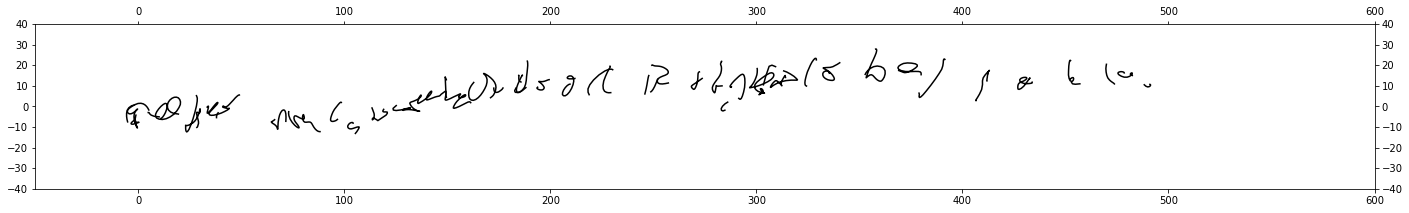

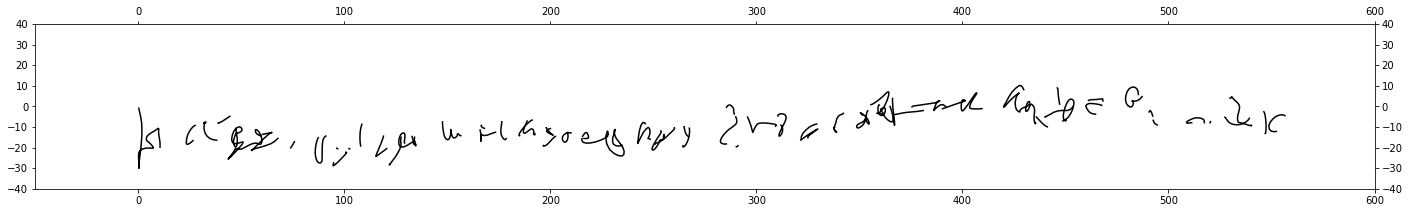

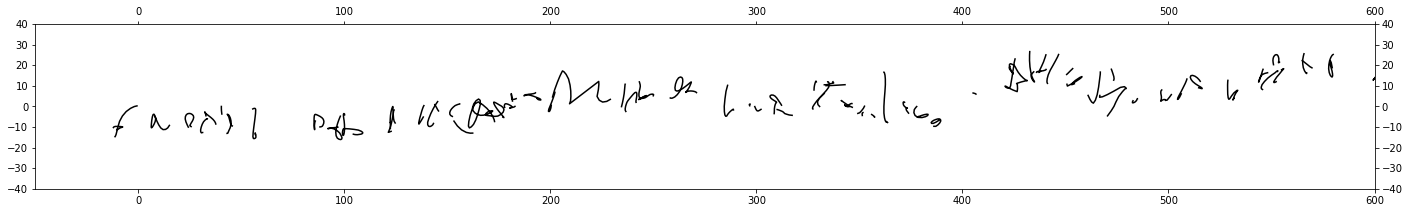

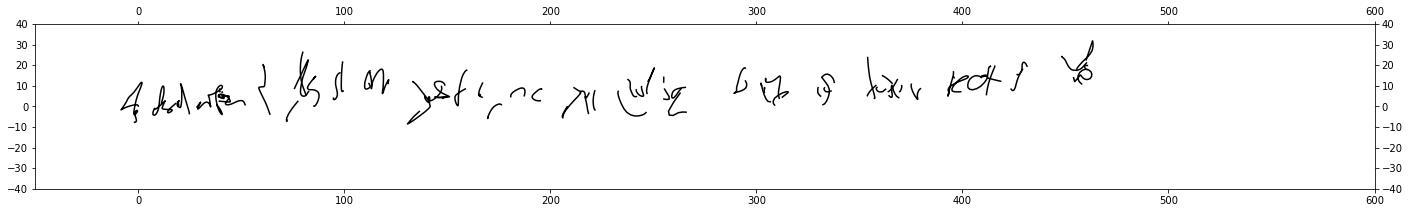

In [51]:
for i in range(20):
    sample_drawing()

In [ ]:
n_epochs = 7
import time

start = time.time()

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(
            model=m, 
            input_strokes=strokes.to(device),
            stroke_lengths=stroke_lens,
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_padding.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

n_iter: 22500 of 4375, loss: -864.3271037597656, timeElapsed: 146.87345504760742
n_iter: 23000 of 4375, loss: -874.6805788574219, timeElapsed: 326.18258452415466
n_iter: 23500 of 4375, loss: -876.6286329345703, timeElapsed: 505.77893924713135
n_iter: 24000 of 4375, loss: -879.0949903564454, timeElapsed: 685.5430738925934
n_iter: 24500 of 4375, loss: -887.3768635253906, timeElapsed: 865.1040363311768
n_iter: 25000 of 4375, loss: -884.179810546875, timeElapsed: 1044.1250612735748


In [ ]:
for i in range(10):
    sample_drawing()

n_iter: 0 of 30000, loss: 3.847310302734375, timeElapsed: 0.11220240592956543
n_iter: 500 of 30000, loss: 2004.0821067504883, timeElapsed: 60.391905069351196
n_iter: 1000 of 30000, loss: 1652.998860687256, timeElapsed: 122.22360348701477
n_iter: 1500 of 30000, loss: 1504.8780248413086, timeElapsed: 184.556307554245
n_iter: 2000 of 30000, loss: 1349.756440460205, timeElapsed: 246.48905515670776
n_iter: 2500 of 30000, loss: 1169.17427444458, timeElapsed: 307.89942812919617
n_iter: 3000 of 30000, loss: 1012.6606830291748, timeElapsed: 371.02262020111084
n_iter: 3500 of 30000, loss: 702.095825471878, timeElapsed: 433.24610209465027
n_iter: 4000 of 30000, loss: 546.4414993247985, timeElapsed: 494.79349422454834
n_iter: 4500 of 30000, loss: 436.102669342041, timeElapsed: 556.7463657855988
n_iter: 5000 of 30000, loss: 251.99758296775818, timeElapsed: 618.2831344604492
n_iter: 5500 of 30000, loss: 188.47319030380248, timeElapsed: 679.9425678253174
n_iter: 6000 of 30000, loss: 194.1795405044555

<Figure size 432x288 with 0 Axes>

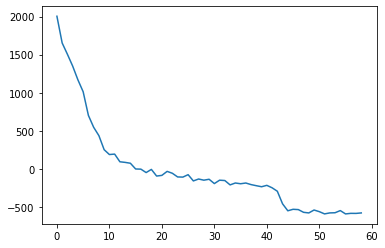

In [23]:
class HandWritingPredictionWithLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_mixtures):
        super(HandWritingPredictionWithLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_mixtures = num_mixtures
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(3*hidden_size, 6*num_mixtures+1)
        
    def forward(self, x, h0, c0):
        out1, _ = self.lstm1(x, (h0, c0))
        out2, _ = self.lstm2(torch.cat((x, out1), -1), (h0, c0))
        out3, _ = self.lstm3(torch.cat((x, out2), -1), (h0, c0))
        out4 = self.linear(torch.cat((out1, out2, out3), -1).reshape(-1, 3*hidden_size))
        return out4

input_size = 3
hidden_size = 500
batch_size = 1
n_mixtures = 1
m = HandWritingPredictionWithLSTM(input_size, hidden_size, n_mixtures).to(device)

def negative_log_likelihood(params, stroke_length, targets=None):   
    #print(params)
    es = 1/(1 + torch.exp(params[:,-1]))
    pis = nn.Softmax(1)(params[:,0:n_mixtures])
    mus = params[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
    sigmas = torch.exp(params[:, 3*n_mixtures:5*n_mixtures].reshape(-1, n_mixtures, 2))
    phos = torch.tanh(params[:, 5*n_mixtures:6*n_mixtures].reshape(-1, n_mixtures, 1))

    covs = torch.zeros(stroke_length-1, n_mixtures, 2, 2, device=device)
    tol = torch.tensor(0.000000001, device=device)
    covs[:,:,0,0] = sigmas[:,:,0] ** 2
    covs[:,:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
    covs[:,:,1,0] = covs[:,:,0,1]
    covs[:,:,1,1] = sigmas[:,:,1] ** 2

    
    distributions = torch.distributions.MultivariateNormal(mus, covs)
    
    target_coords = targets[:,0:2].unsqueeze(1).repeat_interleave(
        torch.tensor([n_mixtures], device=device), dim=1)
    stroke_lift = targets[:,-1]
    
    probs = torch.exp(distributions.log_prob(target_coords))
    #probs = torch.where(probs > 10, torch.zeros_like(probs) + 10, probs)
    probs = torch.where(probs < 0.000000001, torch.zeros_like(probs) + 0.000000001, probs)
#     print(torch.log((pis*probs).sum(dim=1)).sum())
#     print((torch.log(es)*stroke_lift).sum())
#     print((torch.log(1 - es)*(1-stroke_lift)).sum())

    loss = - (torch.log((pis*probs).sum(dim=1))).sum() - (torch.log(es)*stroke_lift).sum() - (torch.log(1 - es)*(1-stroke_lift)).sum()
    #print(loss)
    return loss


def train(model, input_stroke, stroke_len, optimizer, h0, c0):
    #     print(f"stroke: {input_stroke.shape}")
    #     print(f"stroke_len: {stroke_len}")
    #     print(f"h0: {h0.shape}")
    #     print(f"c0: {c0.shape}")
    optimizer.zero_grad()
    out = model(input_stroke[:,:stroke_len-1,:], h0, c0)
    loss = negative_log_likelihood(out, stroke_len, input_stroke[:,1:stroke_len,:].squeeze())
    loss.backward()
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
    
    optimizer.step()
    return loss.item()

print_every = 500
n_epochs = 3
n_iters = 0
losses = []
total_loss = 0

optim = torch.optim.Adam(m.parameters(), lr = 0.00001)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

h0=torch.zeros(batch_size, 1, hidden_size, device=device)
c0=torch.zeros(batch_size, 1, hidden_size, device=device)
he=torch.zeros(batch_size, 1, input_size, device=device)
ce=torch.zeros(batch_size, 1, input_size, device=device)

import time

start = time.time()

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(
            model=m, 
            input_stroke=strokes.to(device),
            stroke_len=stroke_lens.item(),
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model2.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

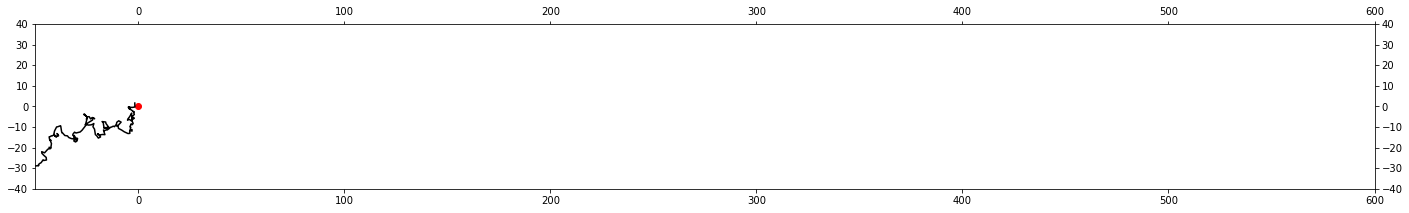

In [53]:
timestamps = 1200

with torch.no_grad():
    h0=torch.zeros(batch_size, 1, hidden_size, device=device)
    c0=torch.zeros(batch_size, 1, hidden_size, device=device)
    predictions = torch.zeros(timestamps, 3, device=device)
    predictions[0, 2] = 1
    for i in range(timestamps-1):
        inp = predictions[i].unsqueeze(0).unsqueeze(1)
        #print(inp.unsqueeze(0).unsqueeze(1))
        #print(h0.shape, c0.shape)
        
        out1, _ = m.lstm1(inp, (h0, c0))
        out2, _ = m.lstm2(torch.cat((inp, out1), -1), (h0, c0))
        out3, _ = m.lstm3(torch.cat((inp, out2), -1), (h0, c0))
        params = m.linear(torch.cat((out1, out2, out3), -1).reshape(-1, 3*hidden_size))

        #print(params)
        es = 1/(1 + torch.exp(params[:,-1]))
        pis = nn.Softmax(1)(params[:,0:n_mixtures])
        mus = params[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
        sigmas = torch.exp(params[:, 3*n_mixtures:5*n_mixtures].reshape(-1, n_mixtures, 2))
        phos = torch.tanh(params[:, 5*n_mixtures:6*n_mixtures].reshape(-1, n_mixtures, 1))

        covs = torch.zeros(n_mixtures, 2, 2, device=device)
        tol = torch.tensor(0.000000001, device=device)
        covs[:,0,0] = sigmas[:,:,0] ** 2
        covs[:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
        covs[:,1,0] = covs[:,0,1]
        covs[:,1,1] = sigmas[:,:,1] ** 2

        mixtures = torch.distributions.MultivariateNormal(mus, covs)
        sample = mixtures.sample().squeeze()
        predictions[i+1, 0] = sample[0]
        predictions[i+1, 1] = sample[1]
        predictions[i+1, 2] = 0#torch.bernoulli(es).item()

drawing.draw(predictions.cpu(), align_strokes=False, denoise_strokes=False)


In [35]:
a = 10000
b = 0
for i in range(a):
    b += torch.bernoulli(torch.tensor(0.9)).item()
b

8995.0

In [108]:
torch.set_printoptions(precision=10)
mus = torch.rand(22, 20, 2)
mus.shape
sigmas = torch.rand(22, 20, 2)
sigmas.shape
phos = torch.rand(22, 20, 1)
phos.shape
covs = torch.zeros(22, 20, 2, 2)
covs[:,:,0,0] = sigmas[:,:,0]**2
covs[:,:,1,1] = sigmas[:,:,1]**2

distributions = torch.distributions.MultivariateNormal(mus, covs)
print(distributions.batch_shape, distributions.event_shape)
targets = torch.rand(22, 2).unsqueeze(1)
targets = targets.repeat_interleave(torch.tensor([20]), dim=1)
targets.shape
lp = torch.exp(distributions.log_prob(targets))
lp.shape
wts = nn.Softmax(1)(torch.rand(22, 20))
wts.shape
lp[1,:]
wts[1,:]
(wts * lp)[1,:]
(wts * lp).shape

torch.Size([22, 20, 2])

torch.Size([22, 20, 2])

torch.Size([22, 20, 1])

torch.Size([22, 20]) torch.Size([2])


torch.Size([22, 20, 2])

torch.Size([22, 20])

torch.Size([22, 20])

tensor([2.3569624126e-01, 2.1319295466e-01, 3.6014885902e+00, 2.5937536359e-01,
        2.3509171009e+00, 1.8440544605e-01, 4.0873944759e-01, 1.0915555954e+00,
        1.0121872276e-01, 6.5111726522e-02, 3.0681800842e-01, 0.0000000000e+00,
        2.0708531141e-01, 1.6538779438e-01, 3.7418460846e-01, 1.7672851682e-02,
        4.0297690034e-01, 2.0239457954e-03, 1.9792731106e-01, 3.3254542351e+00])

tensor([0.0696100071, 0.0577052049, 0.0398469940, 0.0302223898, 0.0613434203,
        0.0288010295, 0.0389507748, 0.0417387374, 0.0657069981, 0.0568057299,
        0.0511838794, 0.0573577546, 0.0648760572, 0.0627077669, 0.0296213962,
        0.0419256724, 0.0491249934, 0.0397933759, 0.0569694042, 0.0557084493])

tensor([1.6406817362e-02, 1.2302342802e-02, 1.4350849390e-01, 7.8389430419e-03,
        1.4421328902e-01, 5.3110667504e-03, 1.5920717269e-02, 4.5560151339e-02,
        6.6507784650e-03, 3.6987191997e-03, 1.5704136342e-02, 0.0000000000e+00,
        1.3434878550e-02, 1.0371099226e-02, 1.1083870195e-02, 7.4094621232e-04,
        1.9796237350e-02, 8.0539633927e-05, 1.1275800876e-02, 1.8525590003e-01])

torch.Size([22, 20])

In [57]:
a = torch.tensor([[1, 2, 3], [1, 2, 3]])
a.shape
torch.sum(a, 0)
torch.sum(a, 1)

torch.Size([2, 3])

tensor([2, 4, 6])

tensor([6, 6])

In [ ]:
class HandWritingPredictionWithLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_mixtures):
        super(HandWritingPredictionWithLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_mixtures = num_mixtures
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(3*hidden_size, 6*num_mixtures+1)
        
    def forward(self, x, h0, c0, he, ce):
        out1, _ = self.lstm1(x, (h0, c0))
        out2, _ = self.lstm2(torch.cat((x, out1), -1), (h0, c0))
        out3, _ = self.lstm3(torch.cat((x, out2), -1), (h0, c0))
        out4 = self.linear(torch.cat((out1, out2, out3), -1).reshape(-1, 3*hidden_size))
        return out4
    
    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, 1, self.hidden_size), torch.zeros(batch_size, 1, self.hidden_size)

def train(model, input_stroke, stroke_len, optimizer, loss_fnc, h0, c0, he, ce):
    #     print(f"stroke: {input_stroke.shape}")
    #     print(f"stroke_len: {stroke_len}")
    #     print(f"h0: {h0.shape}")
    #     print(f"c0: {c0.shape}")
    optimizer.zero_grad()
    out = model(input_stroke[:,:stroke_len-1,:], h0, c0, he, ce)
    #     print(out.shape)
    #     print(input_stroke[:,:stroke_len-1,:].shape)
    assert(out.shape == input_stroke[:,:stroke_len-1,:].shape)
    loss = loss_fnc(out, input_stroke[:,1:stroke_len,:])
    loss.backward()
    optimizer.step()
    return loss
    
input_size = 3
hidden_size = 500
batch_size = 1
m = HandWritingPredictionWithLSTM(input_size, hidden_size).to(device)
optim = torch.optim.Adam(m.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

# s, l = next(iter(train_dataloader))
# loss = train(
#     model=m,
#     input_stroke=s.squeeze(dim=2).to(device),
#     stroke_len=l.item(),
#     optimizer=optim,
#     loss_fnc=loss_function,
#     h0=torch.zeros(batch_size, 1, hidden_size, device=device),
#     c0=torch.zeros(batch_size, 1, hidden_size, device=device),
#     he=torch.zeros(batch_size, 1, input_size, device=device),
#     ce=torch.zeros(batch_size, 1, input_size, device=device))

# torch.save({
#             'epoch': 2,
#             'model_state_dict': m.state_dict(),
#             'optimizer_state_dict': optim.state_dict(),
#             'loss': loss,
#             }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model.pt")

print_every = 500
n_epochs = 10
n_iters = 0
losses = []
total_loss = 0

h0=torch.zeros(batch_size, 1, hidden_size, device=device)
c0=torch.zeros(batch_size, 1, hidden_size, device=device)
he=torch.zeros(batch_size, 1, input_size, device=device)
ce=torch.zeros(batch_size, 1, input_size, device=device)

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(
            model=m, 
            input_stroke=strokes.to(device),
            stroke_len=stroke_lens.item(),
            optimizer=optim,
            loss_fnc=loss_function,
            h0=h0, c0=c0, he=he, ce=ce)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

cuda:0
n_iter: 0 of 100000, loss: 0.005060491617769003
n_iter: 500 of 100000, loss: 2.415259599685669
n_iter: 1000 of 100000, loss: 2.262423038482666
n_iter: 1500 of 100000, loss: 2.371595621109009
n_iter: 2000 of 100000, loss: 2.354013681411743
n_iter: 2500 of 100000, loss: 2.2823498249053955
n_iter: 3000 of 100000, loss: 2.38505482673645
n_iter: 3500 of 100000, loss: 2.282252788543701
n_iter: 4000 of 100000, loss: 2.2105233669281006
n_iter: 4500 of 100000, loss: 2.300356864929199
n_iter: 5000 of 100000, loss: 2.3190813064575195
n_iter: 5500 of 100000, loss: 2.31321120262146
n_iter: 6000 of 100000, loss: 2.2912728786468506
n_iter: 6500 of 100000, loss: 2.245999336242676
n_iter: 7000 of 100000, loss: 2.1940739154815674
n_iter: 7500 of 100000, loss: 2.3092567920684814
n_iter: 8000 of 100000, loss: 2.29649019241333
n_iter: 8500 of 100000, loss: 2.299196720123291
n_iter: 9000 of 100000, loss: 2.2537505626678467
n_iter: 9500 of 100000, loss: 2.3710782527923584
n_iter: 10000 of 100000, loss

In [47]:
timestamps = 1200
with torch.no_grad():
    h0=torch.zeros(batch_size, 1, hidden_size, device=device)
    c0=torch.zeros(batch_size, 1, hidden_size, device=device)
    he=torch.zeros(batch_size, 1, input_size, device=device)
    ce=torch.zeros(batch_size, 1, input_size, device=device)
    predictions = torch.zeros(timestamps, 3, device=device)
    predictions[0, 2] = 1
    for i in range(timestamps-1):
        inp = predictions[i]
        #print(inp.unsqueeze(0).unsqueeze(1))
        #print(h0.shape, c0.shape)
        output, (h0, c0) = m.lstm1(inp.unsqueeze(0).unsqueeze(1), (h0, c0))
        #print(output.shape, h0.shape, c0.shape)
        output, (he, ce) = m.lstm_out(h0, (he, ce))
        #print(output.shape, he.shape, ce.shape)
        predictions[i+1] = he.reshape(-1)
    

    
# start = torch.tensor([0, 0, 1], dtype=torch.float32, device=device)
# with torch.no_grad():
#     a = m(start.unsqueeze(0).unsqueeze(1), h0, c0, he, ce)
# print(a.shape)
# #a[:, :, 2] = a[:, :, 2] > 0.0000001
# #a
# a.reshape(-1)
# a

tensor([[ 0.0000e+00,  0.0000e+00,  1.0000e+00],
        [-1.0651e-01, -1.8280e-01,  1.0190e-07],
        [-2.6253e-01, -3.6974e-01, -2.2414e-06],
        ...,
        [ 1.2201e-02,  3.6043e-02,  9.5921e-03],
        [ 2.0965e-02,  3.4605e-02,  2.9063e-04],
        [ 1.1853e-02,  4.5208e-02,  1.2749e-04]], device='cuda:0')

/tmp/ipykernel_326/3247567841.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions_th = torch.tensor(predictions)


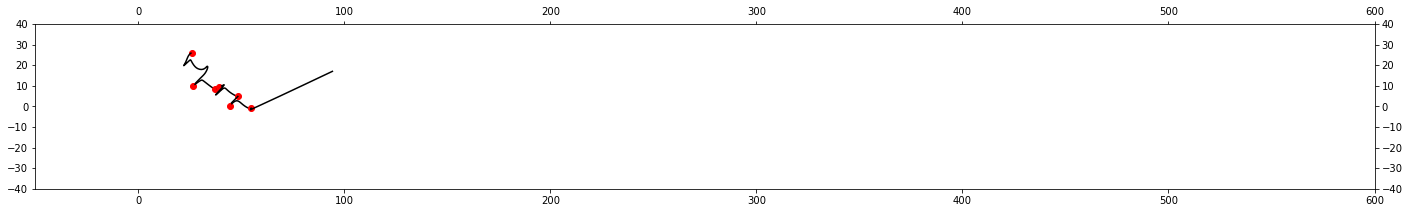

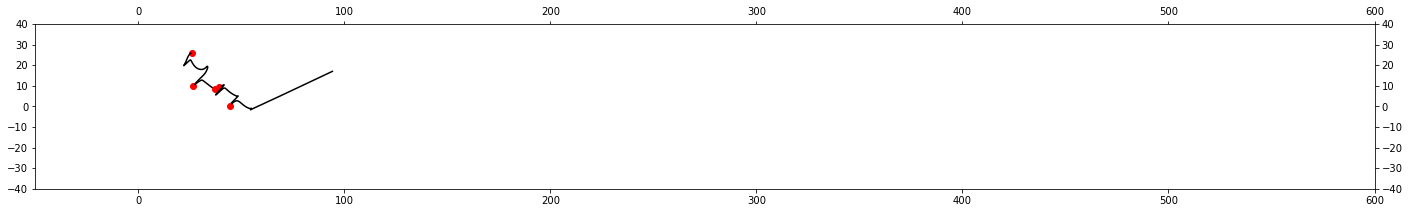

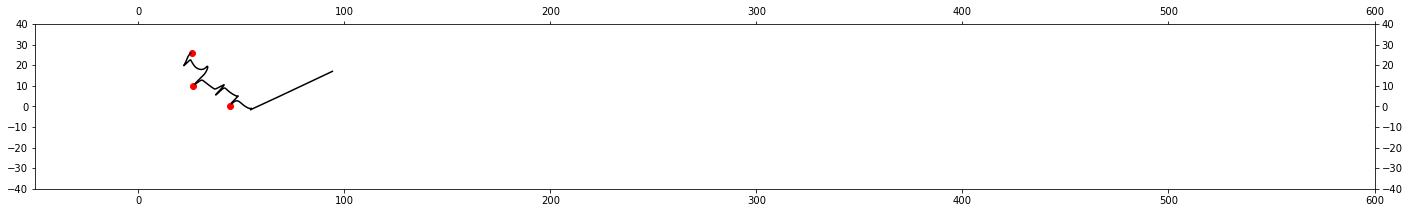

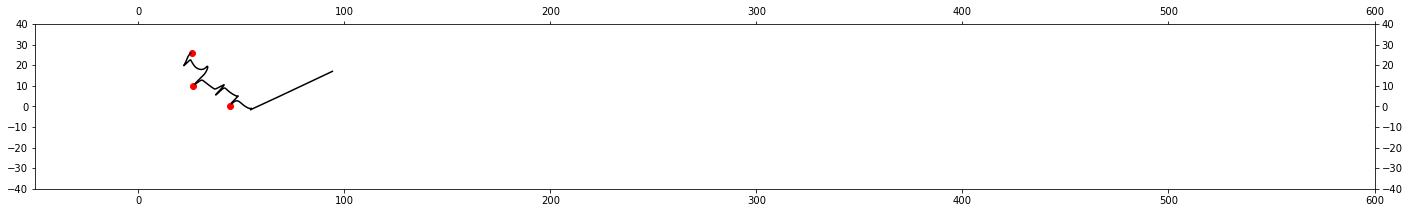

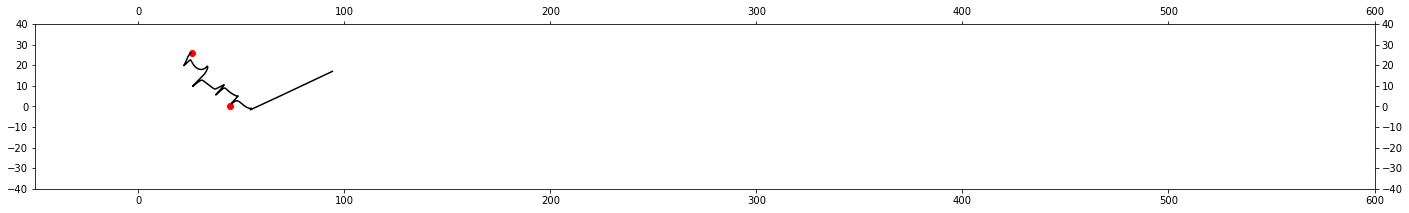

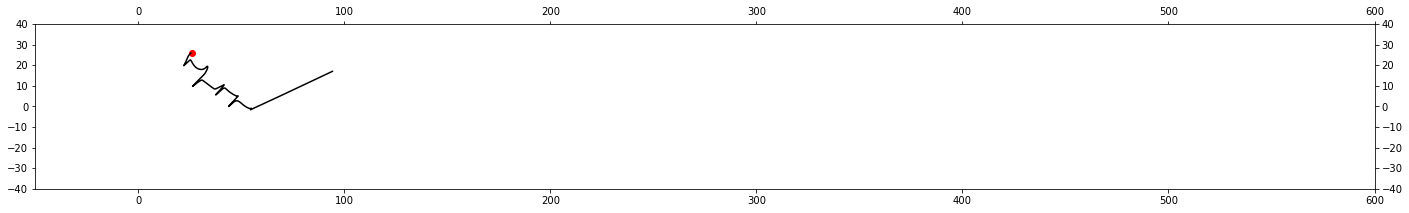

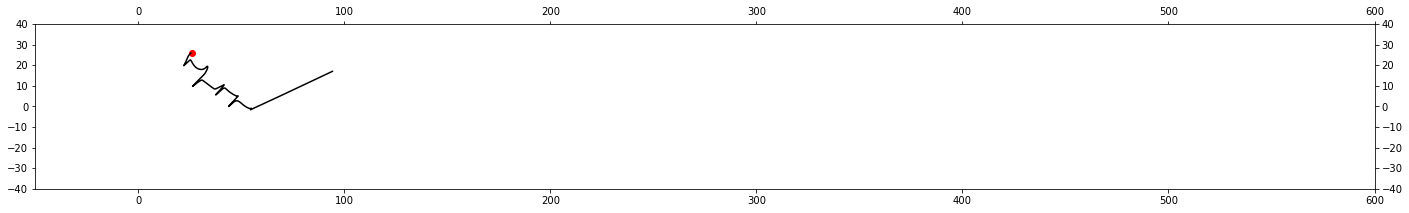

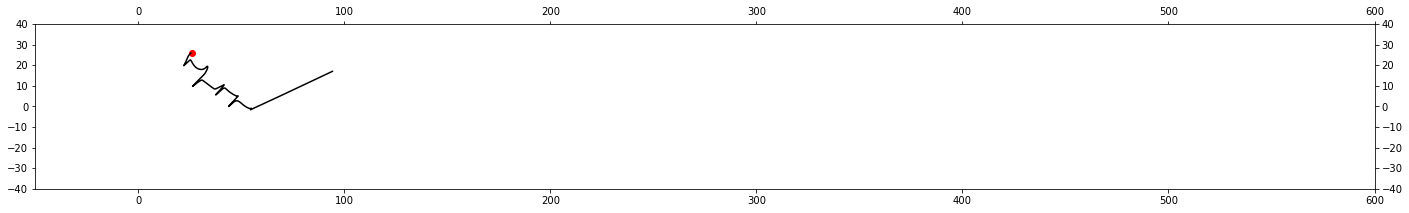

In [48]:
predictions

for threshold in np.arange(0.1, 0.9, 0.1):
    predictions_th = torch.tensor(predictions)
    predictions_th[:, 2] = predictions_th[:, 2] > threshold
    drawing.draw(predictions_th.cpu(), align_strokes=True, denoise_strokes=True)


In [ ]:
def sample(model, predictions):
    with torch.no_grad():
        start = predictions[0]
        for i in range(len(predictions)-1):
            print(model(start.unsqueeze_(0), h0, ).shape()) 
    

In [13]:
class LSTMExp(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMExp, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
    def forward(self, x, h0, c0):
        return self.lstm(x, (h0, c0))
    
input_size = 3
seq_length = 12
hidden_size = 100
batch_size = 10
x = torch.rand(batch_size, seq_length, input_size)
h0 = torch.rand(1, batch_size, hidden_size)
c0 = torch.rand(1, batch_size, hidden_size)
m = LSTMExp(input_size, hidden_size)
out, (hn, cn) = m(x, h0, c0)
print(out.shape)
print(hn.shape)
print(cn.shape)

torch.save({
            'epoch': 2,
            'model_state_dict': m.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': losses[-1],
            }, "model_checkpoints/")

torch.Size([10, 12, 100])
torch.Size([1, 10, 100])
torch.Size([1, 10, 100])


In [46]:
MAX_SEQ_LENGTH = 1200

class HandWritingPrediction(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(HandWritingPrediction, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstmCell1 = nn.LSTMCell(input_size, hidden_size)
        self.lstmCell2 = nn.LSTMCell(hidden_size + input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, input_size)
        self.num_activations = 4 # 2 for each lstm layers
    
    def forward(self, x, activations, idx):
        activations_new[0], activations_new[1] = self.lstmCell1(
            x, (activations_old[0], activations_old[1]))
        activations_new[2], activations_new[3] = self.lstmCell2(
            torch.cat((x, activations_old[2]), 1), (aactivations_old[2], activations_old[3]))
        out = self.linear(activations_old[2])
        return out, activations_old, activations_new
    
    def init_hidden(self, bs, device):
        return torch.zeros(self.num_activations, bs, self.hidden_size).to(device)


In [40]:
def train(model, input_stroke, stroke_len, optimizer, loss_fnc, activations1, activations2):
    optimizer.zero_grad()
    bs = 1
    loss = 0
    for i, pt in enumerate(input_stroke[:stroke_len-1]):
        out, activations = model(pt, activations1, activations2)
        loss += loss_fnc(out, input_stroke[i+1])
    loss = loss/(stroke_len-1)
    loss.backward()
    optimizer.step()
    return loss

In [41]:
def eval(model, input_stroke, stroke_len, loss_fnc, activations):
    with torch.no_grad():
        bs = 1
        loss = 0
        for i, pt in enumerate(input_stroke[:stroke_len-1]):
            out, activations = model(pt, activations, i)
            loss += loss_fnc(out, input_stroke[i+1])
        loss = loss/len(inputs)
        return loss

In [42]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [43]:
batch_size = 1
n_hidden = 1000
n_input = 3

model = HandWritingPrediction(n_input, n_hidden).to(device)
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

    



In [ ]:
def attention_plot(phis):
    plt.rcParams["figure.figsize"] = (12,6)
    phis= phis/(np.sum(phis, axis = 0, keepdims=True))
    plt.xlabel('handwriting generation')
    plt.ylabel('text scanning')
    plt.imshow(phis, cmap='hot', interpolation='nearest', aspect='auto')
    plt.show()